In [89]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [90]:
print(torch.cuda.is_available())

True


In [91]:
# Проверяем, доступны ли GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [92]:
# Загрузка DataFrame из файла
with open(r'./datasets/seg_maps_dataset.pkl', 'rb') as f:
    df = pickle.load(f)

In [71]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

def do_imbalance(df, low=0.05, high=0.3, random_state=None):
    """
    Создает случайный дисбаланс в датасете
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Исходный датасет
    low : float
        Минимальная вероятность сохранения
    high : float
        Максимальная вероятность сохранения  
    random_state : int, optional
        Seed для воспроизводимости. Если None - будет разный результат каждый раз
    """
    unique_classes = df['Crystal'].unique()
    
    # Устанавливаем seed только если он указан
    if random_state is not None:
        np.random.seed(random_state)

    # Задаем вероятность сохранения примера для каждого класса
    keep_probs = np.random.uniform(low=low, high=high, size=len(unique_classes))
    print("Вероятности сохранения для каждого класса:")
    for cls, prob in zip(unique_classes, keep_probs):
        print(f"Класс {cls}: {prob:.2f}")

    selected_indices = []
    for i, class_name in enumerate(unique_classes):
        class_indices = df[df['Crystal'] == class_name].index
        # Для каждого примера в классе решаем, сохранять ли его based on probability
        keep_mask = np.random.random(size=len(class_indices)) < keep_probs[i]
        kept_indices = class_indices[keep_mask]
        selected_indices.extend(kept_indices)

    df_imbalanced_random = df.loc[selected_indices].reset_index(drop=True)
    print("\nСлучайное распределение:")
    print(df_imbalanced_random['Crystal'].value_counts().sort_values())

    # Теперь разделяем этот дисбалансированный датасет
    X_imb = df_imbalanced_random.drop(['Crystal', 'Stats', 'Pulce duration'], axis=1)
    y_imb = df_imbalanced_random['Crystal']

    # Кодируем метки
    label_encoder = LabelEncoder()
    y_imb_encoded = label_encoder.fit_transform(y_imb)

    Stats_imb = df_imbalanced_random['Stats']

    # Разделяем на train/test
    X_train_imb, X_test_imb, Stats_train_imb, Stats_test_imb, y_train_imb, y_test_imb = train_test_split(
        X_imb, Stats_imb, y_imb_encoded, test_size=0.5, random_state=42, stratify=y_imb_encoded
    )

    return X_train_imb, X_test_imb, Stats_train_imb, Stats_test_imb, y_train_imb, y_test_imb, keep_probs

# Теперь при каждом вызове будет разный дисбаланс:
print("Первый вызов:")
X_train_imb1, X_test_imb1, Stats_train_imb1, Stats_test_imb1, y_train_imb1, y_test_imb1, imbalanced1 = do_imbalance(df, low=0.05, high=0.3)

print("\nВторой вызов:")
X_train_imb2, X_test_imb2, Stats_train_imb2, Stats_test_imb2, y_train_imb2, y_test_imb2, imbalanced2 = do_imbalance(df, low=0.05, high=0.3)

Первый вызов:
Вероятности сохранения для каждого класса:
Класс Al: 0.24
Класс Al2O3_sapphire: 0.09
Класс Ba: 0.16
Класс Be: 0.14
Класс BeO: 0.07
Класс C_diamond: 0.17
Класс C_graphite: 0.28
Класс Cr: 0.06
Класс Cs: 0.12
Класс Cu: 0.10
Класс Cu2MnAl: 0.11
Класс Fe: 0.28
Класс Ga: 0.17
Класс Ge: 0.17
Класс He4_hcp: 0.24
Класс I2: 0.09
Класс K: 0.17
Класс Mo: 0.16
Класс Na2Ca3Al2F14: 0.20
Класс Nb: 0.30
Класс Ni: 0.24
Класс Pb: 0.15
Класс Pt: 0.26
Класс Rb: 0.09
Класс Si: 0.06
Класс Ti: 0.10
Класс Tl: 0.14
Класс UO2: 0.18
Класс Zn: 0.20
Класс Y2O3: 0.28

Случайное распределение:
Crystal
Si                 5
Cr                 6
BeO                8
Cu2MnAl           10
I2                10
Al2O3_sapphire    11
Cs                12
Ti                13
Tl                15
Cu                15
Be                16
Rb                17
Ga                17
Na2Ca3Al2F14      18
Pb                18
Mo                20
UO2               20
K                 22
Ge                22
C_diamond 

In [8]:
len(df_imbalanced_random['Crystal'].unique())

30

In [52]:
from torch.utils.data import TensorDataset, DataLoader, random_split

def do_loaders(X_train_imb, X_test_imb, Stats_train_imb, Stats_test_imb, y_train_imb, y_test_imb):
    
    # Преобразование матриц в numpy массив перед преобразованием в тензоры
    X_train_matrices = np.array(X_train_imb['Matrix'].tolist())
    X_test_matrices = np.array(X_test_imb['Matrix'].tolist())

    # Преобразование данных в тензоры PyTorch
    X_train_tensor = torch.FloatTensor(X_train_matrices)
    y_train_tensor = torch.LongTensor(y_train_imb)  # Используем LongTensor для целевых меток

    X_test_tensor = torch.FloatTensor(X_test_matrices)
    y_test_tensor = torch.LongTensor(y_test_imb)

    X_train_tensor = X_train_tensor.unsqueeze(1)
    X_test_tensor = X_test_tensor.unsqueeze(1)

    # Создание набора данных
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    # Создание DataLoader для каждой выборки
    train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)

    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = do_loaders(X_train_imb, X_test_imb, Stats_train_imb, Stats_test_imb, y_train_imb, y_test_imb)

In [53]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

def load_model(num_classes = 30, device = device):

    # Загружаем предобученную ResNet18
    model = models.resnet18(pretrained=True)

    # Изменяем первый сверточный слой
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Инициализируем веса первого слоя
    nn.init.kaiming_normal_(model.conv1.weight, mode='fan_out', nonlinearity='relu')

    # Изменяем последний полносвязный слой для вашего количества классов
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    model.to(device)

    return model

model = load_model(num_classes = 30, device = device)

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.99))

In [42]:
epochs = 10
history = []
history_test = []
num_bach = 0
baches = []

In [61]:
def train_model(model, criterion, optimizer, epochs, train_loader, test_loader):
    
    for i in range(epochs):
    
        model.train()  # Включаем режим обучения
        total_train_loss = 0

        for x_batch, y_batch in train_loader:
            # 1. # загружаем батч данных (вытянутый в линию)
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # 2. вычисляем скор с помощью прямого распространения ( .forward or .__call__ )
            logits = model(x_batch)

            # 3. вычислеяем - функцию потерь (loss)
            loss = criterion(logits, y_batch)

            total_train_loss += loss.item()

            # 4. вычисляем градиенты
            optimizer.zero_grad()
            loss.backward()

            # 5. шаг градиентного спуска
            optimizer.step()

        avg_train_loss = total_train_loss / len(train_loader)

        total_test_loss = 0

        model.eval()
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # Получаем логиты от модели
                outputs = model(inputs)

                test_loss = criterion(outputs, targets)

                total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)

        print(f'Epoch {i+1}, Loss: {avg_train_loss}, Loss test: {avg_test_loss}')

    return model

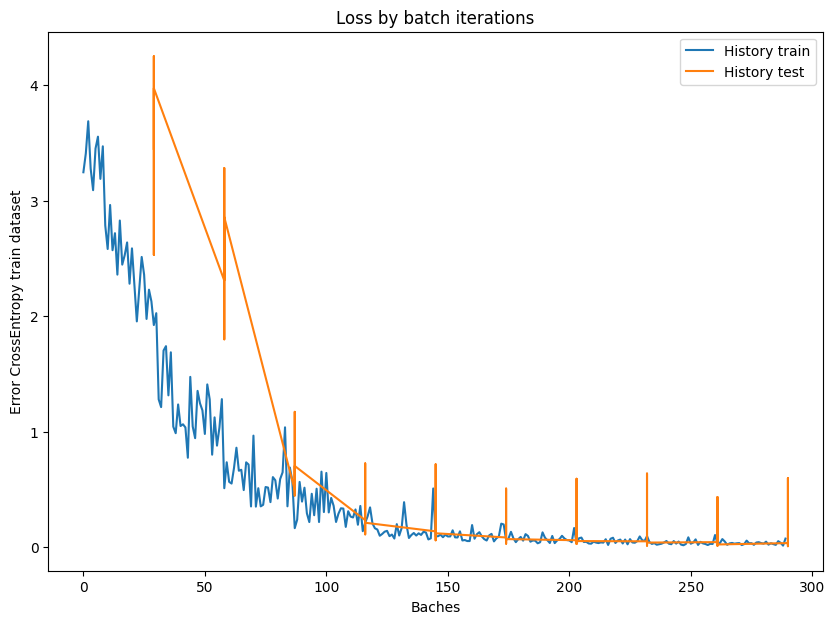

In [44]:
plt.figure(figsize=(10, 7))
plt.plot(history, label = 'History train')
plt.plot(baches, history_test, label = 'History test')
plt.title('Loss by batch iterations')
plt.ylabel('Error CrossEntropy train dataset')
plt.xlabel('Baches')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()

plt.show()

In [56]:
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def get_metrics(model, test_loader):

    # Списки для хранения предсказаний и истинных значений
    all_preds = []
    all_targets = []

    # Отключаем автоматическое вычисление градиентов, так как мы делаем оценку
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # Добавляем предсказания и целевые значения в списки
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Преобразуем списки в numpy-массивы
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Вычисляем метрики на всем датасете
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted')
    recall = recall_score(all_targets, all_preds, average='weighted')
    f1 = f1_score(all_targets, all_preds, average='weighted')

    return accuracy, precision, recall, f1

In [73]:
num_tests = 10

metrics = []
imbalances = []

for _ in range(num_tests):
    
    X_train_imb, X_test_imb, Stats_train_imb, Stats_test_imb, y_train_imb, y_test_imb, imb = do_imbalance(df, low=0.05, high=0.3)

    imbalances.append(imb)

    train_loader, test_loader = do_loaders(X_train_imb, X_test_imb, Stats_train_imb, Stats_test_imb, y_train_imb, y_test_imb)

    model = load_model(num_classes = 30, device = device)

    criterion = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.99))

    epochs = 10

    model = train_model(model, criterion, optimizer, epochs, train_loader, test_loader)

    accuracy, precision, recall, f1 = get_metrics(model, test_loader)

    metrics.append([accuracy, precision, recall, f1])

Вероятности сохранения для каждого класса:
Класс Al: 0.26
Класс Al2O3_sapphire: 0.07
Класс Ba: 0.26
Класс Be: 0.14
Класс BeO: 0.20
Класс C_diamond: 0.09
Класс C_graphite: 0.07
Класс Cr: 0.10
Класс Cs: 0.08
Класс Cu: 0.13
Класс Cu2MnAl: 0.18
Класс Fe: 0.20
Класс Ga: 0.25
Класс Ge: 0.21
Класс He4_hcp: 0.20
Класс I2: 0.15
Класс K: 0.17
Класс Mo: 0.15
Класс Na2Ca3Al2F14: 0.26
Класс Nb: 0.11
Класс Ni: 0.05
Класс Pb: 0.21
Класс Pt: 0.10
Класс Rb: 0.27
Класс Si: 0.26
Класс Ti: 0.07
Класс Tl: 0.08
Класс UO2: 0.17
Класс Zn: 0.20
Класс Y2O3: 0.12

Случайное распределение:
Crystal
C_graphite         6
Ni                 8
Ti                 9
Tl                 9
Al2O3_sapphire    10
Cu                11
Cs                12
Nb                12
C_diamond         12
Pt                13
K                 14
Cr                15
Be                17
I2                17
Mo                19
Y2O3              19
BeO               22
Pb                22
Cu2MnAl           24
He4_hcp           25
Fe 

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.5685524517490017, Loss test: 3.3558747306946786
Epoch 2, Loss: 1.0821468118698365, Loss test: 2.508955163340415
Epoch 3, Loss: 0.5150030880205093, Loss test: 0.47061135764083556
Epoch 4, Loss: 0.24715086096717465, Loss test: 0.26855889106950454
Epoch 5, Loss: 0.12740630476224807, Loss test: 0.1872271409919185
Epoch 6, Loss: 0.07368459600594736, Loss test: 0.1544073790071472
Epoch 7, Loss: 0.05240136222733605, Loss test: 0.13637931867232245
Epoch 8, Loss: 0.041272417311706854, Loss test: 0.11312702358249695
Epoch 9, Loss: 0.033865797754016616, Loss test: 0.1073964224948037
Epoch 10, Loss: 0.025191946045285272, Loss test: 0.10829047474168962
Вероятности сохранения для каждого класса:
Класс Al: 0.25
Класс Al2O3_sapphire: 0.29
Класс Ba: 0.27
Класс Be: 0.10
Класс BeO: 0.17
Класс C_diamond: 0.14
Класс C_graphite: 0.15
Класс Cr: 0.14
Класс Cs: 0.26
Класс Cu: 0.16
Класс Cu2MnAl: 0.18
Класс Fe: 0.30
Класс Ga: 0.06
Класс Ge: 0.17
Класс He4_hcp: 0.24
Класс I2: 0.09
Класс K: 0.20


C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.5904698756433304, Loss test: 3.440696962418095
Epoch 2, Loss: 1.1367156928585422, Loss test: 2.9854030993676957
Epoch 3, Loss: 0.5142923420475375, Loss test: 0.5340267006428011
Epoch 4, Loss: 0.23670883813211996, Loss test: 0.21769582528260448
Epoch 5, Loss: 0.13933131435225088, Loss test: 0.15441662968406755
Epoch 6, Loss: 0.0716299656778574, Loss test: 0.12819104701761277
Epoch 7, Loss: 0.05253259915738336, Loss test: 0.09508065413683653
Epoch 8, Loss: 0.03451933513485616, Loss test: 0.08264172458720784
Epoch 9, Loss: 0.02530728109301098, Loss test: 0.0848595613403426
Epoch 10, Loss: 0.028931616414939205, Loss test: 0.0729669546182718
Вероятности сохранения для каждого класса:
Класс Al: 0.23
Класс Al2O3_sapphire: 0.27
Класс Ba: 0.16
Класс Be: 0.09
Класс BeO: 0.13
Класс C_diamond: 0.16
Класс C_graphite: 0.23
Класс Cr: 0.05
Класс Cs: 0.13
Класс Cu: 0.24
Класс Cu2MnAl: 0.22
Класс Fe: 0.23
Класс Ga: 0.25
Класс Ge: 0.25
Класс He4_hcp: 0.22
Класс I2: 0.16
Класс K: 0.30
Кла

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.5134598341855137, Loss test: 3.489578933426828
Epoch 2, Loss: 0.9690967346682693, Loss test: 2.1318628029389814
Epoch 3, Loss: 0.4399379509868044, Loss test: 0.4104662971063094
Epoch 4, Loss: 0.2122905764615897, Loss test: 0.2525683678122181
Epoch 5, Loss: 0.10310063025716579, Loss test: 0.2085260506154913
Epoch 6, Loss: 0.06424830837005918, Loss test: 0.17572059877442592
Epoch 7, Loss: 0.04176003920535246, Loss test: 0.17116077695832108
Epoch 8, Loss: 0.03051712400646824, Loss test: 0.15320177778432315
Epoch 9, Loss: 0.023058924217228636, Loss test: 0.16057541315218038
Epoch 10, Loss: 0.021259091145387203, Loss test: 0.15216907868020688


C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnin

Вероятности сохранения для каждого класса:
Класс Al: 0.14
Класс Al2O3_sapphire: 0.28
Класс Ba: 0.30
Класс Be: 0.29
Класс BeO: 0.23
Класс C_diamond: 0.19
Класс C_graphite: 0.20
Класс Cr: 0.18
Класс Cs: 0.23
Класс Cu: 0.15
Класс Cu2MnAl: 0.22
Класс Fe: 0.08
Класс Ga: 0.12
Класс Ge: 0.26
Класс He4_hcp: 0.28
Класс I2: 0.18
Класс K: 0.06
Класс Mo: 0.28
Класс Na2Ca3Al2F14: 0.23
Класс Nb: 0.15
Класс Ni: 0.20
Класс Pb: 0.16
Класс Pt: 0.17
Класс Rb: 0.27
Класс Si: 0.09
Класс Ti: 0.08
Класс Tl: 0.05
Класс UO2: 0.13
Класс Zn: 0.09
Класс Y2O3: 0.10

Случайное распределение:
Crystal
K                  3
Tl                 5
Fe                 6
Zn                 8
Si                 8
Y2O3              12
Ti                12
UO2               15
Pt                16
C_diamond         16
C_graphite        17
Ga                17
Nb                18
I2                18
Pb                18
Cu                20
Al                20
Cs                21
Cr                21
Ni                21
Al2

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.526776049286127, Loss test: 3.297473892569542
Epoch 2, Loss: 1.1168038854375482, Loss test: 2.243700236082077
Epoch 3, Loss: 0.6142725315876305, Loss test: 0.4256081960629672
Epoch 4, Loss: 0.3798225421924144, Loss test: 0.3142647750210017
Epoch 5, Loss: 0.2233980444725603, Loss test: 0.18933758829371072
Epoch 6, Loss: 0.18292441952507943, Loss test: 0.154833417996997
Epoch 7, Loss: 0.16075414890656248, Loss test: 0.13537742031621747
Epoch 8, Loss: 0.1773772947199177, Loss test: 0.13131780008552596
Epoch 9, Loss: 0.1518825904931873, Loss test: 0.15793676250905264
Epoch 10, Loss: 0.16468638306832872, Loss test: 0.10335193669016007
Вероятности сохранения для каждого класса:
Класс Al: 0.25
Класс Al2O3_sapphire: 0.21
Класс Ba: 0.16
Класс Be: 0.29
Класс BeO: 0.08
Класс C_diamond: 0.10
Класс C_graphite: 0.14
Класс Cr: 0.11
Класс Cs: 0.21
Класс Cu: 0.06
Класс Cu2MnAl: 0.09
Класс Fe: 0.12
Класс Ga: 0.22
Класс Ge: 0.27
Класс He4_hcp: 0.25
Класс I2: 0.10
Класс K: 0.19
Класс Mo: 

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.360008083283901, Loss test: 3.390657015144825
Epoch 2, Loss: 0.9135797042399645, Loss test: 1.9453742392361164
Epoch 3, Loss: 0.3822330180555582, Loss test: 0.38498497591353953
Epoch 4, Loss: 0.16812607273459435, Loss test: 0.2092345100827515
Epoch 5, Loss: 0.10697754169814289, Loss test: 0.1529567934339866
Epoch 6, Loss: 0.0674744825810194, Loss test: 0.14397613640176132
Epoch 7, Loss: 0.055598058563191444, Loss test: 0.15972560399677604
Epoch 8, Loss: 0.033191944792633876, Loss test: 0.10775468360225204
Epoch 9, Loss: 0.029185734092607163, Loss test: 0.1036317619291367
Epoch 10, Loss: 0.016934079467318952, Loss test: 0.10241591150406748
Вероятности сохранения для каждого класса:
Класс Al: 0.08
Класс Al2O3_sapphire: 0.19
Класс Ba: 0.20
Класс Be: 0.10
Класс BeO: 0.15
Класс C_diamond: 0.26
Класс C_graphite: 0.09
Класс Cr: 0.16
Класс Cs: 0.28
Класс Cu: 0.18
Класс Cu2MnAl: 0.23
Класс Fe: 0.26
Класс Ga: 0.10
Класс Ge: 0.10
Класс He4_hcp: 0.24
Класс I2: 0.24
Класс K: 0.07
К

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.5959333142926617, Loss test: 3.5761569699933453
Epoch 2, Loss: 1.0412993296500175, Loss test: 2.49492552972609
Epoch 3, Loss: 0.45607250736605737, Loss test: 0.413921253815774
Epoch 4, Loss: 0.21533255206961785, Loss test: 0.22532677638434595
Epoch 5, Loss: 0.10738362624279914, Loss test: 0.16010075819588476
Epoch 6, Loss: 0.07627850758933252, Loss test: 0.16560316380233533
Epoch 7, Loss: 0.07101762751417776, Loss test: 0.13797523501899936
Epoch 8, Loss: 0.05541045441021843, Loss test: 0.10530785612401462
Epoch 9, Loss: 0.02688486955218738, Loss test: 0.10184369437516697
Epoch 10, Loss: 0.01752530875044965, Loss test: 0.07870230108739869
Вероятности сохранения для каждого класса:
Класс Al: 0.11
Класс Al2O3_sapphire: 0.28
Класс Ba: 0.10
Класс Be: 0.22
Класс BeO: 0.29
Класс C_diamond: 0.08
Класс C_graphite: 0.15
Класс Cr: 0.11
Класс Cs: 0.11
Класс Cu: 0.08
Класс Cu2MnAl: 0.21
Класс Fe: 0.24
Класс Ga: 0.22
Класс Ge: 0.28
Класс He4_hcp: 0.09
Класс I2: 0.13
Класс K: 0.14
Кл

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.4857759440646454, Loss test: 3.38894522190094
Epoch 2, Loss: 0.890115416225265, Loss test: 2.010476392858169
Epoch 3, Loss: 0.39451276730088625, Loss test: 0.3251078525448547
Epoch 4, Loss: 0.16481446978800438, Loss test: 0.24951545631184296
Epoch 5, Loss: 0.10696430635802887, Loss test: 0.19218569632400484
Epoch 6, Loss: 0.05721548878971268, Loss test: 0.1669698545764036
Epoch 7, Loss: 0.042870787355829686, Loss test: 0.14028728030183735
Epoch 8, Loss: 0.04150397963274051, Loss test: 0.12561261319719694
Epoch 9, Loss: 0.027818033992148498, Loss test: 0.1400408773573444
Epoch 10, Loss: 0.018962908139014068, Loss test: 0.13049860954668155
Вероятности сохранения для каждого класса:
Класс Al: 0.09
Класс Al2O3_sapphire: 0.29
Класс Ba: 0.28
Класс Be: 0.07
Класс BeO: 0.26
Класс C_diamond: 0.17
Класс C_graphite: 0.24
Класс Cr: 0.09
Класс Cs: 0.08
Класс Cu: 0.27
Класс Cu2MnAl: 0.27
Класс Fe: 0.17
Класс Ga: 0.27
Класс Ge: 0.22
Класс He4_hcp: 0.10
Класс I2: 0.13
Класс K: 0.08
Кл

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.5948302779878887, Loss test: 3.4691916601998467
Epoch 2, Loss: 1.027872270345688, Loss test: 1.73575519323349
Epoch 3, Loss: 0.493573676262583, Loss test: 0.33435945468289513
Epoch 4, Loss: 0.28909402979271753, Loss test: 0.24077400629009518
Epoch 5, Loss: 0.2162620875452246, Loss test: 0.3137158192694187
Epoch 6, Loss: 0.17839950738208635, Loss test: 0.13212197667786052
Epoch 7, Loss: 0.14968543526317393, Loss test: 0.10075163141425167
Epoch 8, Loss: 0.10699793520782674, Loss test: 0.08864167449729783
Epoch 9, Loss: 0.12749593066317694, Loss test: 0.12275892537353295
Epoch 10, Loss: 0.11585929377802781, Loss test: 0.07101473788331662
Вероятности сохранения для каждого класса:
Класс Al: 0.12
Класс Al2O3_sapphire: 0.08
Класс Ba: 0.15
Класс Be: 0.30
Класс BeO: 0.09
Класс C_diamond: 0.26
Класс C_graphite: 0.21
Класс Cr: 0.05
Класс Cs: 0.29
Класс Cu: 0.29
Класс Cu2MnAl: 0.28
Класс Fe: 0.18
Класс Ga: 0.11
Класс Ge: 0.15
Класс He4_hcp: 0.20
Класс I2: 0.14
Класс K: 0.23
Класс

C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 2.635961574892844, Loss test: 3.320505480612478
Epoch 2, Loss: 1.1824498734166544, Loss test: 2.5434375116902013
Epoch 3, Loss: 0.5626523350515673, Loss test: 0.626435270232539
Epoch 4, Loss: 0.2620274840343383, Loss test: 0.28642281265028063
Epoch 5, Loss: 0.13146109758846222, Loss test: 0.2052133226346585
Epoch 6, Loss: 0.07072489864883884, Loss test: 0.179110266208168
Epoch 7, Loss: 0.053971431969154264, Loss test: 0.16272648471978404
Epoch 8, Loss: 0.04077887435954425, Loss test: 0.14379765309633746
Epoch 9, Loss: 0.03231233884129794, Loss test: 0.1416056676196956
Epoch 10, Loss: 0.03611050681361268, Loss test: 0.1631107448389934


C:\Users\neUral\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


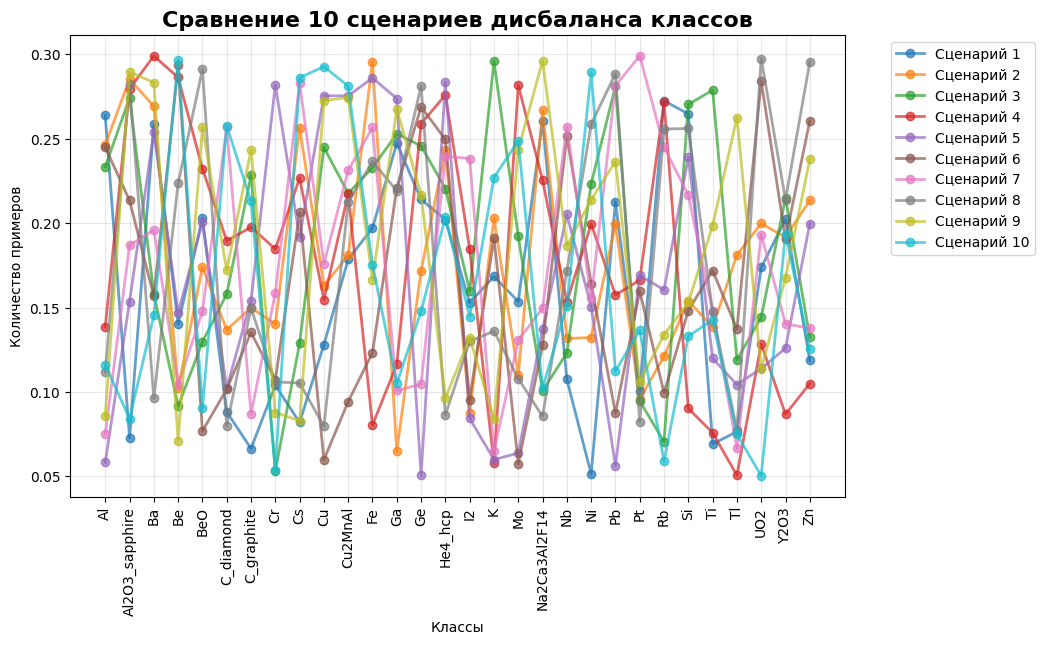

In [ ]:
original_counts = df['Crystal'].value_counts().sort_index()
crystal_names = original_counts.index.tolist()

n_scenarios = len(imbalances)
n_classes = len(crystal_names)

# Создаем большую фигуру с несколькими субплогами
plt.figure(figsize=(10, 6))
plt.title('Сравнение 10 сценариев дисбаланса классов', fontsize=16, fontweight='bold')

# 1. Линейный график всех распределений
x_pos = np.arange(n_classes)
for i, imb in enumerate(imbalances):
    plt.plot(x_pos, imb, marker='o', label=f'Сценарий {i+1}', alpha=0.7, linewidth=2)

#axes[0, 0].plot(x_pos, original_counts.values, marker='s', label='Исходный', color='black', linewidth=3)
plt.xlabel('Классы')
plt.ylabel('Количество примеров')
plt.xticks(x_pos)
plt.xticks(ticks=range(len(crystal_names)), labels=crystal_names, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

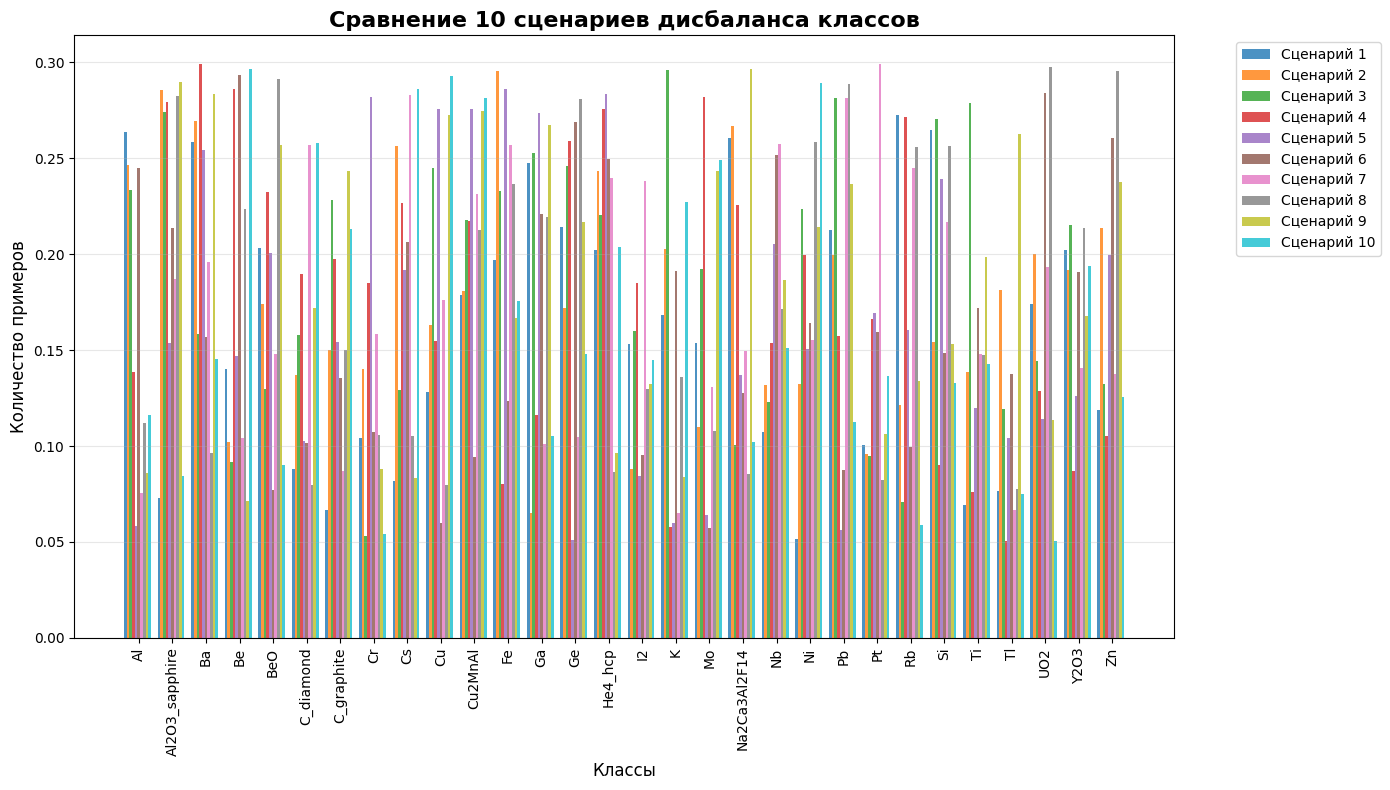

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Преобразуем в DataFrame для удобства
scenario_data = []
for i, imb in enumerate(imbalances):
    for j, count in enumerate(imb):
        scenario_data.append({
            'Сценарий': f'Сценарий {i+1}',
            'Класс': crystal_names[j],
            'Количество': count
        })

df_scenarios = pd.DataFrame(scenario_data)

# Создаем группированный столбчатый график
plt.figure(figsize=(14, 8))
x_pos = np.arange(n_classes)
width = 0.08  # ширина столбцов

for i in range(n_scenarios):
    positions = x_pos + i * width - (n_scenarios * width) / 2
    plt.bar(positions, imbalances[i], width=width, 
            label=f'Сценарий {i+1}', alpha=0.8)

plt.xlabel('Классы', fontsize=12)
plt.ylabel('Количество примеров', fontsize=12)
plt.title('Сравнение 10 сценариев дисбаланса классов', fontsize=16, fontweight='bold')
plt.xticks(x_pos, crystal_names, rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

C:\Users\neUral\AppData\Local\Temp\ipykernel_14496\2481099778.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[i].legend()


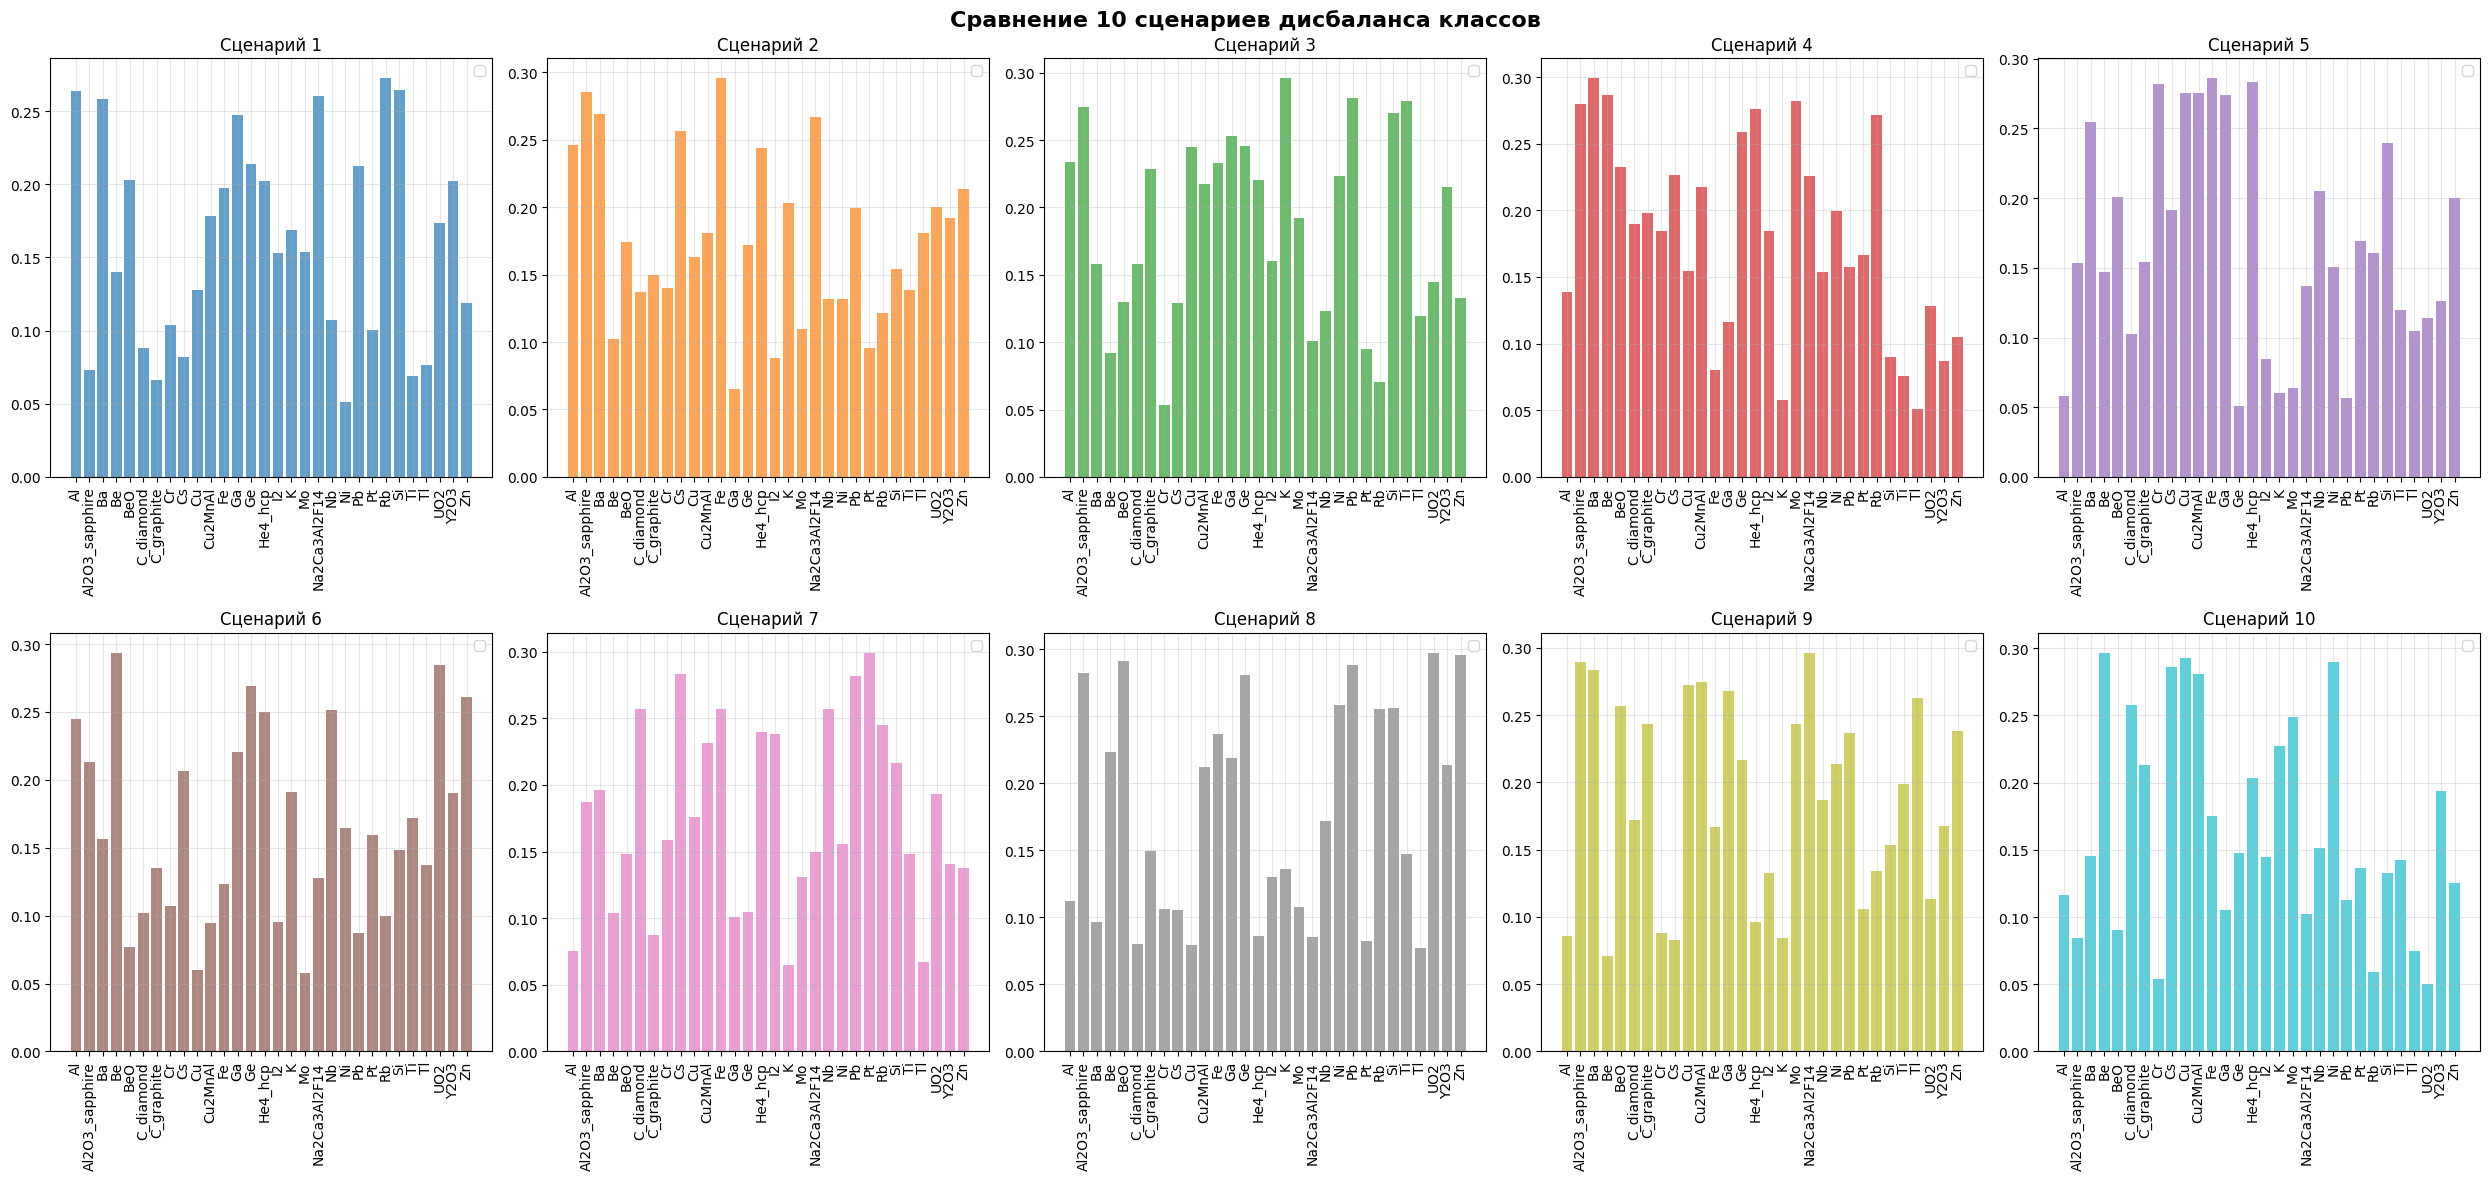

In [88]:
fig, axes = plt.subplots(2, 5, figsize=(25, 12))
axes = axes.flatten()

for i, imb in enumerate(imbalances):
    axes[i].bar(crystal_names, imb, alpha=0.7, color=f'C{i}')
    axes[i].set_title(f'Сценарий {i+1}')
    axes[i].tick_params(axis='x', rotation=90)
    axes[i].grid(True, alpha=0.3)
    
    # Добавляем исходное распределение для сравнения
    axes[i].legend()

plt.suptitle('Сравнение 10 сценариев дисбаланса классов', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

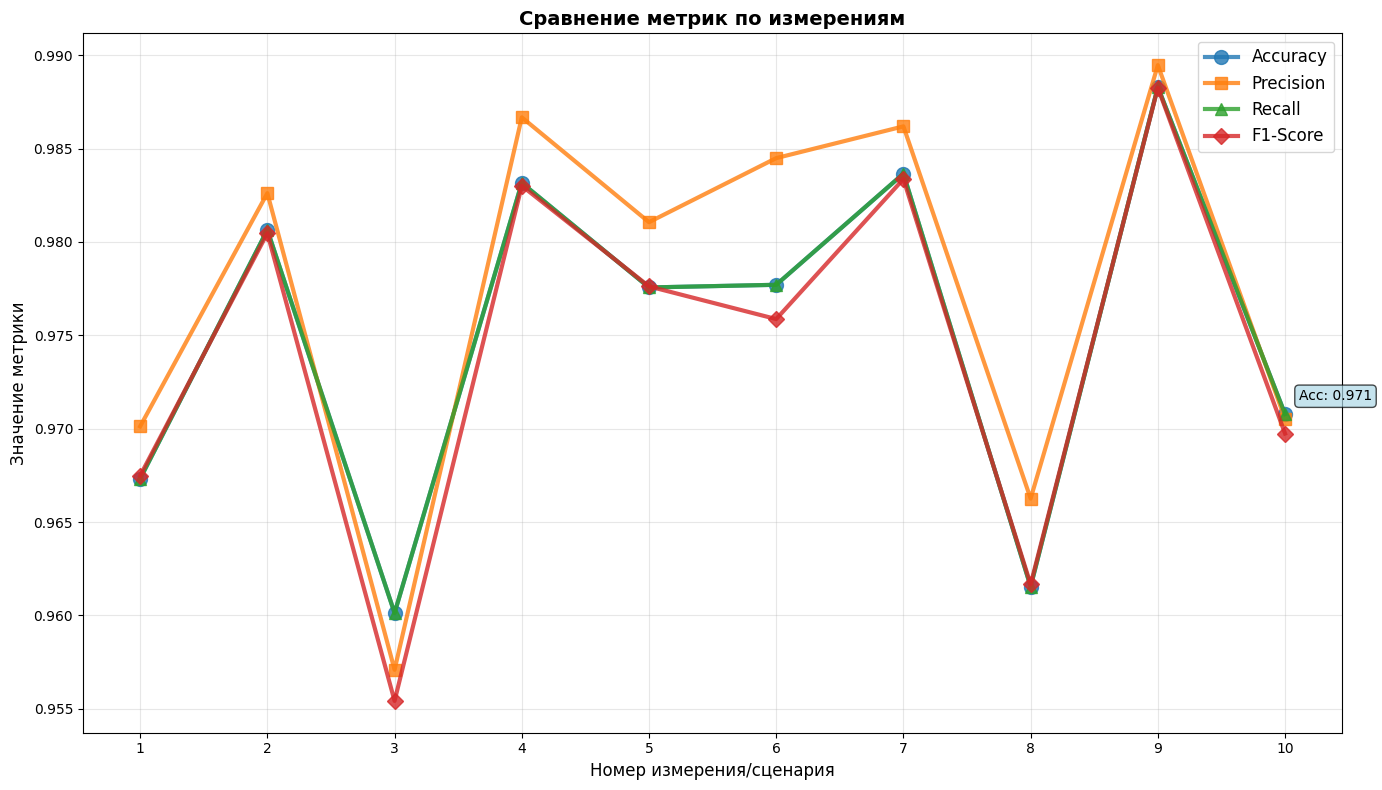

In [77]:
def plot_metrics_comparison(metrics, title="Сравнение метрик по измерениям"):
    """
    Все метрики на одном графике для удобного сравнения
    """
    accuracies = [sample[0] for sample in metrics]
    precisions = [sample[1] for sample in metrics]
    recalls = [sample[2] for sample in metrics]
    f1_scores = [sample[3] for sample in metrics]
    
    n_measurements = len(metrics)
    x = range(1, n_measurements + 1)
    
    plt.figure(figsize=(14, 8))
    
    plt.plot(x, accuracies, 'o-', linewidth=3, markersize=10, label='Accuracy', alpha=0.8)
    plt.plot(x, precisions, 's-', linewidth=3, markersize=8, label='Precision', alpha=0.8)
    plt.plot(x, recalls, '^-', linewidth=3, markersize=8, label='Recall', alpha=0.8)
    plt.plot(x, f1_scores, 'D-', linewidth=3, markersize=8, label='F1-Score', alpha=0.8)
    
    plt.xlabel('Номер измерения/сценария', fontsize=12)
    plt.ylabel('Значение метрики', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.xticks(x)
    
    # Добавляем значения последнего измерения для ориентира
    plt.annotate(f'Acc: {accuracies[-1]:.3f}', 
                xy=(n_measurements, accuracies[-1]), 
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

plot_metrics_comparison(metrics, title="Сравнение метрик по измерениям")

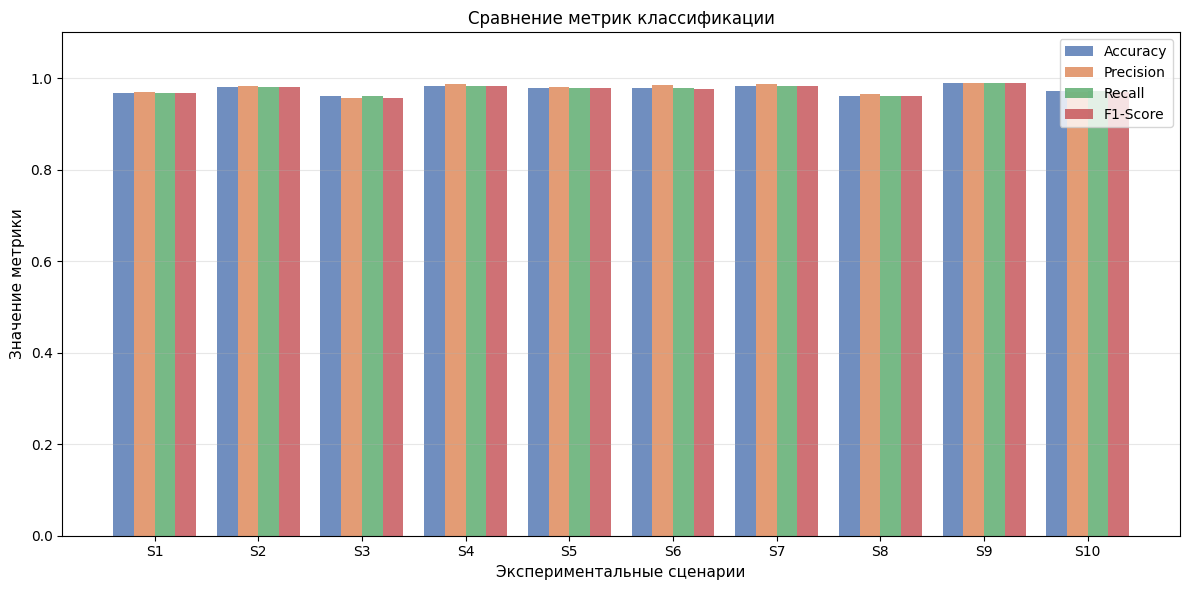

In [78]:
def plot_grouped_metrics_compact(metrics, title="Сравнение метрик классификации"):
    """
    Компактная версия для научной статьи
    """
    metrics_array = np.array(metrics)
    n_measurements = len(metrics)
    
    # Параметры
    bar_width = 0.2
    x = np.arange(n_measurements)
    colors = ['#4C72B0', '#DD8452', '#55A868', '#C44E52']  # Цвета для научных публикаций
    metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    plt.figure(figsize=(12, 6))
    
    for i in range(4):
        values = metrics_array[:, i]
        plt.bar(x + i * bar_width, values, bar_width, 
                label=metric_labels[i], 
                color=colors[i],
                alpha=0.8)
    
    plt.xlabel('Экспериментальные сценарии', fontsize=11)
    plt.ylabel('Значение метрики', fontsize=11)
    plt.title(title, fontsize=12)
    plt.xticks(x + bar_width * 1.5, [f'S{i+1}' for i in range(n_measurements)])
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3, axis='y')
    plt.ylim(0, 1.1)
    
    # Чистый вид для статьи
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')  # Для сохранения в статью
    plt.show()

# Использование компактной версии
plot_grouped_metrics_compact(metrics)

In [75]:
for sample in metrics:
    print(f'Accuracy {sample[0]}')
    print(f'Precision {sample[1]}')
    print(f'Recall {sample[2]}')
    print(f'F1 {sample[3]}')
    print('--------------------')


Accuracy 0.9673202614379085
Precision 0.9701220644203101
Recall 0.9673202614379085
F1 0.9674845696355948
--------------------
Accuracy 0.9806451612903225
Precision 0.982616487455197
Recall 0.9806451612903225
F1 0.9804734514046367
--------------------
Accuracy 0.9601226993865031
Precision 0.957083707170397
Recall 0.9601226993865031
F1 0.9554160814560198
--------------------
Accuracy 0.9831649831649831
Precision 0.9866762866762867
Recall 0.9831649831649831
F1 0.9830090377458799
--------------------
Accuracy 0.9775641025641025
Precision 0.9810606060606062
Recall 0.9775641025641025
F1 0.9776205514256984
--------------------
Accuracy 0.9777070063694268
Precision 0.9844928956393926
Recall 0.9777070063694268
F1 0.9758712749720618
--------------------
Accuracy 0.9836601307189542
Precision 0.9861939077625353
Recall 0.9836601307189542
F1 0.9833730088314864
--------------------
Accuracy 0.9615384615384616
Precision 0.9662546854854547
Recall 0.9615384615384616
F1 0.9616594269639062
---------------

Accuracy: 0.99
Precision (Weighted): 0.99
Recall (Weighted): 0.99
F1-Score (Weighted): 0.99


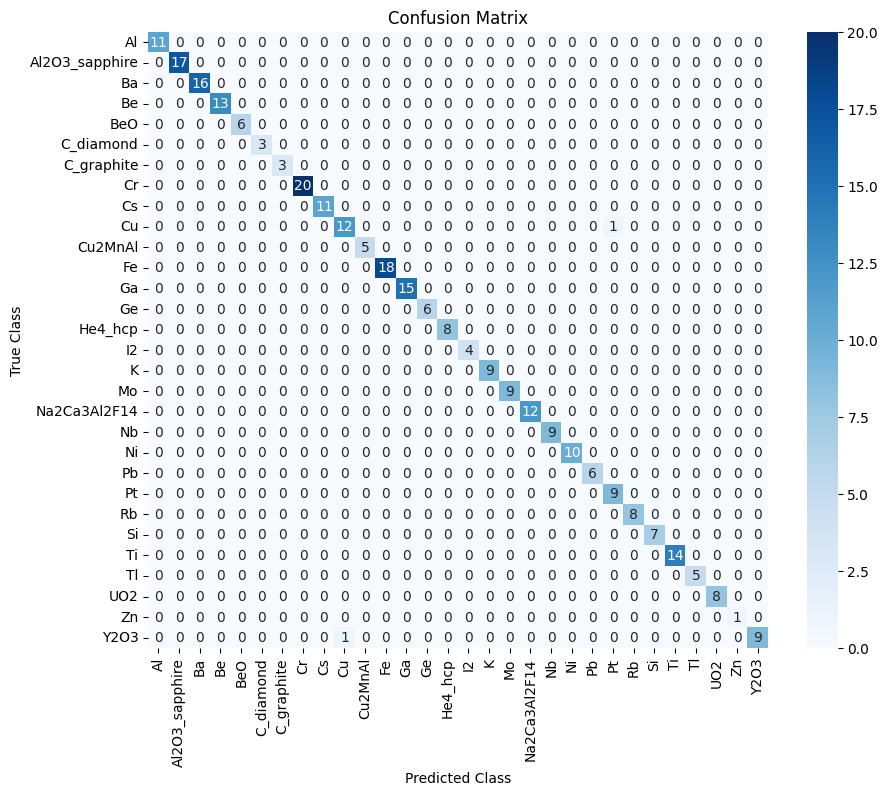

In [48]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision (Weighted): {precision:.2f}")
print(f"Recall (Weighted): {recall:.2f}")
print(f"F1-Score (Weighted): {f1:.2f}")

# Построение и визуализация матрицы ошибок
conf_matrix = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=df_imbalanced_random['Crystal'].unique(), yticklabels=df_imbalanced_random['Crystal'].unique())
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()